In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, lfilter , filtfilt
import pandas as pd
import scipy as sp
import os
import sys
import seaborn as sb 
from matplotlib import cm

import biosppy.signals
import pickle


# Retrieve Data

In [6]:
##  retrieve tensors ##
file = open('tensor_dump.pkl', 'rb')
raw_data_to_tensor = pickle.load(file)
amplitude_data_to_tensor  = pickle.load(file)
muscles_to_tensor = pickle.load(file)
elecs_to_tensor = pickle.load(file)

file.close()

In [7]:
## retrieve muscle and elec names

df_electrodes = pd.read_csv("df_electrodes.csv")
df_muscles= pd.read_csv("df_muscles.csv")

# Set Functions

## Take muscle name and get the muscle nr, data tensor, amplitudes tensor and max EMG value

### Get the index nr for a muscle

In [195]:
def get_nr_for_muscle(muscle_name, df_muscles): # Input muscle_name Eg. "RRF"
    """
    Get index number of a muscle
    
    Parameters:
    - muscle_name String the name of the muscle 
    - df_muscle pandas df of the muscles and indeces
    
    Returns:
    - muscle_nr int index of the muscle
    """
    print("function 'get_nr_for_muscle' has been called")
    muscle_nr=df_muscles.index.where(df_muscles.muscle_name==muscle_name).dropna().astype(int)[0]
    print(f"For muscle name: {muscle_name} the index number is: {muscle_nr} ")
 
    return int(muscle_nr)

In [196]:
muscle_nr=get_nr_for_muscle("RRF", df_muscles)# Input muscle_name Eg. "Vlat"

function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 


### Get the raw data for a muscle

In [197]:
def get_raw_data_for_muscle(muscle_name, df_muscles, raw_data_to_tensor): # Input muscle_name Eg. "Vlat"
    """
    Get raw data tensor

    Parameters:
    - muscle_name String the name of the muscle 
    - df_muscle pandas df of the muscles and indeces
    - raw_data_to_tensor 5D tensor all the raw data of all the muscles
    Returns:
    - data_tensor_muscle_i 4D tensor with the raw data for the muscle

    """
    print("function 'get_raw_data_for_muscle' has been called")
    muscle_nr=get_nr_for_muscle(muscle_name, df_muscles)
    data_tensor_muscle_i=raw_data_to_tensor[:,muscle_nr,:,:,:] #returns a tensor of size([16, 32, 11, 1404])
    return data_tensor_muscle_i

In [198]:
data_tensor_muscle_i= get_raw_data_for_muscle("RRF", df_muscles, raw_data_to_tensor)

function 'get_raw_data_for_muscle' has been called
function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 


### Get the amplitude data for a muscle

In [199]:
## Make a function that given a muscle name, returns the data tensor and amplitudes tensor related to this muscle. ##
def get_amplitude_data_for_muscle(muscle_name, df_muscles, amplitude_data_to_tensor): # Input muscle_name Eg. "Vlat"
    """
    Get amplitude data tensor
    
    Parameters:
    - muscle_name String the name of the muscle 
    - df_muscle pandas df of the muscles and indeces
    - amplitude_data 3D tensor all the amplitude data of all the muscles
    Returns:
    tuple with:
    - amplitude_tensor_muscle_i 2D tensor with the amplitude data for the muscle
    """
   
    print("function 'gget_amplitude_data_for_muscle' has been called")
    muscle_nr=get_nr_for_muscle(muscle_name, df_muscles)
    amplitude_tensor_muslce_i=amplitude_data_to_tensor[:, muscle_nr, :] #returns a tensor of size([16, 32])
    
    return amplitude_tensor_muslce_i 

   

In [200]:
amplitude_tensor_muslce_i=get_amplitude_data_for_muscle("RRF", df_muscles, amplitude_data_to_tensor)

function 'gget_amplitude_data_for_muscle' has been called
function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 


### Get the max EMG value for a muscle

In [201]:

def get_max_emg(muscle_name, df_muscles, raw_data_to_tensor ): # Input muscle_name Eg. "Vlat"
    """
    This function gets the max value out of all the EMG values of a muscle
    
    Parameters:
    - muscle_name string the name of the muscle 
    - raw_data_to_tensor 5D tensor all the raw data of all the muscles

    Returns:
    - max_emg tensor the maximum emg value from all the values of the muscle, for normalisation
    """
    print("function 'get_max_emg' has been called")
    muscle_nr= get_nr_for_muscle(muscle_name, df_muscles)
    max_emg=np.nanmax(raw_data_to_tensor[:, muscle_nr, :, :, :])
    max_emgs=torch.tensor(max_emg)  #get tensor
    print(f"max_emg: {max_emg}")
    return max_emg



In [202]:
max_emg=get_max_emg("RRF", df_muscles, raw_data_to_tensor) 


function 'get_max_emg' has been called
function 'get_nr_for_muscle' has been called
For muscle name: RRF the index number is: 12 
max_emg: 3.583035469055176


## Take a single EMG time series and computes its peak-to-peak time series.

### Get Peak to peak Value

In [205]:

def get_peak_to_peak(EMG_time_series, window_size): 
    """
    This function returns an array and plot of peak to peak values for a given Time-series and window size
    Parameters:
    - EMG_time_series tensor an emg data series 
    - widow_size integer number of timepoints per window 

    Return:
    - peak_to_peak_values tensor a tensor the peak to peak values for each windwo of the given time_series
    """
    print("function 'get_peak_to_peak' has been called")
    
    ### get peak_to_peak_value for each window ###
    peak_to_peak_values=[]
    windows_per_trial=EMG_time_series.unfold(0, window_size, 1)
    for window in windows_per_trial:
        max_y=np.nanmax(window) # find max and min for every window neglecting NAN
        min_y=np.nanmin(window)
        peak_to_peak_values.append(max_y-min_y) #calculate peak-to-peak for every window
    peak_to_peak_values=torch.tensor(peak_to_peak_values)  #get tensor

    ### set equal size for peak_to_peak_value and EMG_time_series (filled with zeros) ###
    target_len = EMG_time_series.size(dim=0)
    peak_to_peak_values=torch.nn.functional.pad(peak_to_peak_values, (0, target_len - peak_to_peak_values.size(dim=0)))
    print(EMG_time_series.size())
    print(peak_to_peak_values.size())
    
    ### plot results ###
    figure, axis = plt.subplots(1, 2)
    #Plot EMG values
    axis[0].plot(EMG_time_series)
    axis[0].set(ylabel='EMG response')
    axis[0].set_title("Time series")
   
    # Plot peak to peak values
    axis[1].plot(peak_to_peak_values)
    axis[1].set( ylabel='Peak-to_peak value')
    axis[1].yaxis.set_label_position("right")
    axis[1].yaxis.tick_right()
    axis[1].set_title("Peak to peak analysis of time series")
    plt.show()
    
    return peak_to_peak_values




function 'get_peak_to_peak' has been called
torch.Size([1404])
torch.Size([1404])


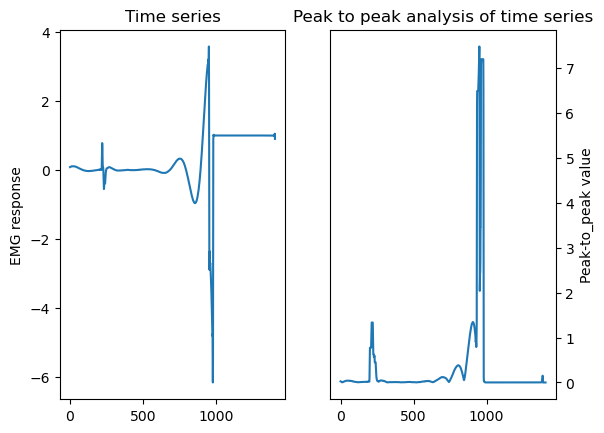

In [209]:
peak_to_peak_values= get_peak_to_peak(raw_data_to_tensor[12,12,21,4,:], 20)

In [40]:
print(df_muscles)

    Unnamed: 0 muscle_name
0            0         LST
1            1         RST
2            2         LTA
3            3         LMG
4            4        LSol
5            5       LVLat
6            6         LRF
7            7         LIl
8            8        RSol
9            9         RMG
10          10         RTA
11          11       RVLat
12          12         RRF
13          13         RIl
